# What makes A successful Airbnb Listing?: Review Sentiment Analysis.

# Objective: Do sentiment analysis of airbnb reviews in Portland and look for features that can explain positive and negative reviews.

- Text preprocessing and setup (Jake)
- Visualization and Correlation (Waranya)
- Modeling (Jonny)

## Data
- listings.csv
- reviews.csv
- neighbourhoods.geojson


In [75]:

from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
import pandas as pd
import re
from datetime import date
import numpy as np
import geopandas as gpd
import matplotlib.pyplot as plt
import csv
from itertools import chain
from nltk.corpus import stopwords
from textblob import TextBlob
import nltk
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import RegexpTokenizer
import ast
from textblob import TextBlob
import warnings
warnings.filterwarnings("ignore")
from transformers import AutoTokenizer
from transformers import AutoModelForSequenceClassification
from scipy.special import softmax
import pandas as pd
from time import time
import torch
from datetime import datetime
from transformers import AutoTokenizer
from transformers import AutoModelForSequenceClassification
from scipy.special import softmax
import pandas as pd
from datetime import datetime

from functools import reduce
from itertools import chain
import ast
import seaborn as sns
from nicknames import NickNamer
RERUN=False
RUN_ROBERTA=False
#nltk.download('all')


# Look at reviews data


In [76]:
original_data=pd.read_csv('reviews.csv')
original_data.head()


,listing_id,id,date,reviewer_id,reviewer_name,comments
0,12899,24767,2010-01-24,69327,Stuart,"Recommended! Very good value for a spacious, a..."
1,12899,29230,2010-03-13,72846,John,Our ten days visiting in Portland were enormou...
2,12899,29806,2010-03-16,84196,Lois,We had a wonderful time staying in the area of...
3,12899,32572,2010-03-31,89114,Troy,I stayed at Ali and David's place when I first...
4,12899,32862,2010-04-02,100318,Cathy,"Clean, comfortable, quiet rooms; easygoing gen..."


In [77]:
original_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 470436 entries, 0 to 470435
Data columns (total 6 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   listing_id     470436 non-null  int64 
 1   id             470436 non-null  int64 
 2   date           470436 non-null  object
 3   reviewer_id    470436 non-null  int64 
 4   reviewer_name  470436 non-null  object
 5   comments       470365 non-null  object
dtypes: int64(3), object(3)
memory usage: 21.5+ MB


# Data Cleaning-Looking at the data we can see that html br tags and new line characters need to be removed from the comments field

In [78]:
print(original_data['comments'].iloc[13:17].to_markdown())

|    | comments                                                                                                                                                                                                                                                                                                                                                                            |
|---:|:------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------|
| 13 | Unfortunately we weren't able to chat too much with Ali or David, because we were so busy, and they seem lovely!                                                                                                                       

In [79]:
def removeTags():
    L=[]
    with open('reviews.csv','r') as f:
        reader=csv.reader(f)
        c=0
        for row in reader:
            X=clean(row[5])
            L.append([row[0],row[1],row[2],row[3],row[4],X])
    with open('reviews_clean.csv','w') as f2:
        writer=csv.writer(f2)
        for row in L:
            writer.writerow(row)   
def clean(s):
    try:
        X=re.sub('<br/>'," ",s)
        X=re.sub("\n","",X)
        return X.strip()
    except:
        print(s)
    return s.strip()

# Remove html Tags

In [80]:
removeTags()
reviews=pd.read_csv('reviews_clean.csv').dropna(subset=['comments'])


In [81]:
#original_data['comments']=original_data['comments'].str.strip().str.replace("<br/>","").str.replace("\n","").str.replace('\n\n',"")

print(reviews['comments'].iloc[13:17].to_markdown())



|    | comments                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                        |
|---:|:----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

# Preparing Data for Vader sentiment Analyzer  and LDA Topic Modeling.
    -Contraction Replacement
    -Removing some but not all Punctuation.  The vader sentiment analyzer can interpret punctuation such as exclamation points, so you do not want to remove them.
    -Lemmatizing: Getting words in their root form.
    -Removing Stop Words (Words that do not convey meaning)

In [82]:
class TextNormalization:
    def __init__(self,df,column):
        self.stop_words=[item for item in stopwords.words('english') if item!='not']
        contraction_patterns = [(r'can\'t', 'cannot'),
                                (r'haven\'t', 'have not'),
                                (r'wasn\'t', 'was not'),
                                (r'isn\'t', 'is not'),
                                (r'didn\'t', 'did not'),
                                (r'hasn\'t', 'has not'),
                                (r'weren\'t', 'were not'),
                                (r'don\'t','do not'),
                               (r'couldn\'t','could not')]
        self.contraction_regexes = [(re.compile(p), replaced_text) for p, replaced_text in contraction_patterns]
        self.wntl=WordNetLemmatizer()
        self.df=df.copy()
        self.column=column
        self.applyAll()
    def removeStopWords(self,s):
        word_tokens=nltk.word_tokenize(s)
        return [self.wntl.lemmatize(word) for word in word_tokens if word.lower() not in self.stop_words]

    def do_contraction_normalization(self, text): #Method taken from async material
        for contraction_regex, replaced_text in self.contraction_regexes:
            text = contraction_regex.sub(replaced_text, text)
        return text

    def normalize(self,text):
        cleaned_tokens=self.removeStopWords(self.standardizeAdjectives(self.removePunctuation(self.do_contraction_normalization(text))))
        return pd.Series([cleaned_tokens,len(cleaned_tokens)])
    def applyAll(self):
        self.df[["Tokens",'Corpus_Length']]=self.df[self.column].apply(self.normalize)
        return self.df
    def get(self):
        return self.df

    def removePunctuation(self,s):
        patterns=[(r"-"," "),
                  (r"\.",''),
                  (r',',''),
                  (r'\)',''),
                  (r'\(',''),
                  (r"\'",""),
                 (r';',"")]
        compiled_patterns=[(re.compile(pattern),replaced_text) for pattern,replaced_text in patterns]
        for pattern,replacement in compiled_patterns:
            s=pattern.sub(replacement,s)
        return s

    def standardizeAdjectives(self,s):
        s = re.sub('comfy', 'comfortable', s, flags=re.IGNORECASE)
        s = re.sub('not clean', 'dirty', s, re.IGNORECASE)
        s = re.sub('not comfortable', 'uncomfortable', s, re.IGNORECASE)
        s = re.sub('not comfortable', 'uncomfortable', s, re.IGNORECASE)
        s = re.sub('great', 'good', s, re.IGNORECASE)
        s = re.sub('convenient', 'good', s, re.IGNORECASE)
        s = re.sub('inconvenient', 'bad', s, re.IGNORECASE)
        s = re.sub('nice', 'good', s, re.IGNORECASE)
        s = re.sub('awesome', 'good', s, re.IGNORECASE)
        s = re.sub('terrible', 'bad', s, re.IGNORECASE)
        s = re.sub('horrible', 'bad', s, re.IGNORECASE)
        s = re.sub('cute', 'good', s, re.IGNORECASE)
        s = re.sub('not good', 'bad', s, re.IGNORECASE)
        s = re.sub('not great', 'bad', s, re.IGNORECASE)
        return s
  





### Now we have two new columns "Tokens" and "Corpus_Length".  The corpus length column can be interpreted as the number of meaningful words in the review.

In [83]:
if RERUN:
    reviews=TextNormalization(reviews,'comments').get()
    reviews.to_csv('stepOne.csv',index=False)



# Perform Vader Sentiment Analysis

##### Let's look at the reviews after creating the tokens

In [84]:
reviews=pd.read_csv('stepOne.csv')
reviews.iloc[13:17]

,listing_id,id,date,reviewer_id,reviewer_name,comments,Tokens,Corpus_Length
13,12899,68414,2010-07-24,170065,Hope,Unfortunately we weren't able to chat too much...,"['Unfortunately', 'not', 'able', 'chat', 'much...",53
14,12899,71418,2010-07-31,89041,Ariel,We couldn't have asked for much more from our ...,"['could', 'not', 'asked', 'much', 'host', '!',...",22
15,12899,74541,2010-08-06,174803,Marilyn,"This was a perfect space in a charming, conven...","['perfect', 'space', 'charming', 'good', 'neig...",12
16,12899,75259,2010-08-07,189922,Kathy,"Very clean, quiet, friendly hosts. We enjoyed...","['clean', 'quiet', 'friendly', 'host', 'enjoye...",16


In [85]:
#Vader sentiment class takes a dataframe and a column to perform sentiment analysis on.  Returns new dataframe with
#sentiment score columns
#reviews[['id','Tokens',"Corpus_Length"]].to_csv('UpdatedTokens.csv')
class sentimentVader:
    def __init__(self,df,column):
        self.df=df
        self.column=column
        self.sentimentAnalyzer=SentimentIntensityAnalyzer()
        self.applyAll()
    def getSentimentVader(self,toks):
        s=" ".join(toks)
        #s=toks
        sent = self.sentimentAnalyzer.polarity_scores(s)
        return pd.Series([float(sent['compound']),float(sent['neg']),float(sent['pos']),float(sent['neu'])])
    def applyAll(self):
        self.df[['sentimentVader','negVader','posVader','neutralVader']]=self.df[self.column].apply(self.getSentimentVader)
    def get(self): 
        return self.df

In [86]:
if RERUN:
    reviews=sentimentVader(reviews,'Tokens').get()

    reviews.to_csv('stepTwo.csv', index=False)


# Take a look at data after Vader sentiment analysis.

In [87]:
reviews=pd.read_csv('stepTwo.csv')
reviews.iloc[13:17]


,listing_id,id,date,reviewer_id,reviewer_name,comments,Tokens,Corpus_Length,sentimentVader,negVader,posVader,neutralVader
13,12899,68414,2010-07-24,170065,Hope,Unfortunately we weren't able to chat too much...,"['Unfortunately', 'not', 'able', 'chat', 'much...",53,0.9909,0.0,0.095,0.905
14,12899,71418,2010-07-31,89041,Ariel,We couldn't have asked for much more from our ...,"['could', 'not', 'asked', 'much', 'host', '!',...",22,0.9738,0.0,0.120,0.880
15,12899,74541,2010-08-06,174803,Marilyn,"This was a perfect space in a charming, conven...","['perfect', 'space', 'charming', 'good', 'neig...",12,0.7424,0.0,0.057,0.943
16,12899,75259,2010-08-07,189922,Kathy,"Very clean, quiet, friendly hosts. We enjoyed...","['clean', 'quiet', 'friendly', 'host', 'enjoye...",16,0.9325,0.0,0.106,0.894


# Add  columns for adjectives and nouns to the dataframe.  Use TextBlob.

In [88]:
class contractionReplacer:
    def __init__(self,contraction_patterns):
        self.contraction_regexes=[(re.compile(p),replaced_text) for p, replaced_text in contraction_patterns]
        
    def do_contraction_normalization(self,text):
        for contraction_regex, replaced_text in self.contraction_regexes:
            text=contraction_regex.sub(replaced_text, text)
        return text
#takes a string and returns a pd.Series containing fields for nouns, adjectives, and noun adjective pairs. 

def standardizeAdjectives(s):
    s = re.sub('comfy', 'comfortable', s, flags=re.IGNORECASE)
    s = re.sub('not clean', 'dirty', s, re.IGNORECASE)
    s = re.sub('not comfortable', 'uncomfortable', s, re.IGNORECASE)
    s = re.sub('not comfortable', 'uncomfortable', s, re.IGNORECASE)
    s = re.sub('great', 'good', s, re.IGNORECASE)
    s = re.sub('horrible', 'bad', s, re.IGNORECASE)
    s = re.sub('cute', 'good', s, re.IGNORECASE)
    s = re.sub('not good', 'bad', s, re.IGNORECASE)
    s = re.sub('not great', 'bad', s, re.IGNORECASE)
    return s

def PartsOfSpeech(s):
    stop_words=[item for item in stopwords.words('english') if item!='not']
    
    patterns = [(r'can\'t', 'cannot'),
                        (r'haven\'t', 'have not'),
                        (r'wasn\'t', 'was not'),
                        (r'isn\'t', 'is not'),
                        (r'didn\'t', 'did not'),
                        (r'hasn\'t', 'has not'),
                        (r'weren\'t', 'were not'),
                        (r'don\'t','do not'),
                        (r"-"," "),
                        (r"\.",''),
                        (r',',''),
                        (r'\)',''),
                        (r'\(','') 
                                ]

    X=contractionReplacer(patterns)
    s=X.do_contraction_normalization(s)
    nouns = []
    adjectives = []
    adjective_nouns=[]
    pos = TextBlob(s).tags
    pos=[item for item in pos if item[0] not in stop_words]
    
    for i in range(len(pos)):
        if 'NN' in pos[i][1] and 'P' not in pos[i][1]:
            nouns.append(pos[i][0])
        if 'JJ' in pos[i][1]:
            adj=pos[i][0]
                          
            if i>1:
                for item in pos[i-2:i]:
                    if item[0].lower()=='not':
                        adj=item[0]+" "+adj
                        break
            if i<len(pos)-1 and 'NN' in pos[i+1][1]:
                following=pos[i+1][0]
                adjective_nouns.append(adj+" "+following)
            adjectives.append(standardizeAdjectives(adj))
            
    return pd.Series([nouns, adjectives, adjective_nouns])




# Example of what is being achieved with the PartsOfSpeech function.

In [89]:
s="This place had ugly furniture, The refrigerator wasn't cold. doesn't have a Washer.\
 There weren't any restaurants nearby.  The place wasn't clean when we arrived.  Overall the place just wasn't comfy"

s2="What a gem.  Their were tons of cool bars and restaurants nearby.  It could have been warmer but i wasn't uncomfortable"
print(PartsOfSpeech(s))
print("\n")
print(PartsOfSpeech(s2))


0    [place, refrigerator, restaurants, place, place]
1            [not cold, Washer, dirty, uncomfortable]
2                                                  []
dtype: object


0       [gem, tons, bars, restaurants]
1    [cool, warmer, not uncomfortable]
2                          [cool bars]
dtype: object


## Example of what TextBlob.tags does

In [90]:
TextBlob(s).tags

[('This', 'DT'),
 ('place', 'NN'),
 ('had', 'VBD'),
 ('ugly', 'RB'),
 ('furniture', 'NN'),
 ('The', 'DT'),
 ('refrigerator', 'NN'),
 ('was', 'VBD'),
 ("n't", 'RB'),
 ('cold', 'JJ'),
 ('does', 'VBZ'),
 ("n't", 'RB'),
 ('have', 'VB'),
 ('a', 'DT'),
 ('Washer', 'NNP'),
 ('There', 'EX'),
 ('were', 'VBD'),
 ("n't", 'RB'),
 ('any', 'DT'),
 ('restaurants', 'NNS'),
 ('nearby', 'RB'),
 ('The', 'DT'),
 ('place', 'NN'),
 ('was', 'VBD'),
 ("n't", 'RB'),
 ('clean', 'JJ'),
 ('when', 'WRB'),
 ('we', 'PRP'),
 ('arrived', 'VBD'),
 ('Overall', 'PDT'),
 ('the', 'DT'),
 ('place', 'NN'),
 ('just', 'RB'),
 ('was', 'VBD'),
 ("n't", 'RB'),
 ('comfy', 'JJ')]

In [91]:
if RERUN:
    reviews[['nouns','adjectives','adjectives_with_nouns']]=reviews['comments'].apply(PartsOfSpeech)
    reviews.to_csv('stepThree.csv')


In [92]:
reviews=pd.read_csv('stepThree.csv')
reviews[['nouns','adjectives','adjectives_with_nouns']].head(7)


,nouns,adjectives,adjectives_with_nouns
0,"['value', 'airy', 'floor']","['good', 'spacious', 'upper', 'welcoming', 'he...","['good value', 'spacious airy', 'upper floor']"
1,"['days', 'warmth', 'accomodations']","['ten', 'economical', 'lucky']","['ten days', 'economical accomodations']"
2,"['time', 'area', 'beds', 'comfy', 'upstairs', ...","['wonderful', 'spacious', 'good', 'amazing', '...","['wonderful time', 'great food', 'amazing home..."
3,"['place', 'space', 'lots', 'room', 'neighborho...","['comfortable', 'private', 'knowledgeable']","['private lots', 'knowledgeable Portland']"
4,"['rooms', 'hosts', 'neighborhood', 'parks', 'r...","['comfortable', 'quiet', 'generous', 'good', '...","['quiet rooms', 'generous hosts', 'unlimited r..."
5,"['neighborhood', 'convenient', 'airport', 'int...","['Beautiful', 'considerate', 'comfortable', 's...","['Beautiful neighborhood', 'considerate hosts'..."
6,"['space', 'adults', 'wife', 'sister', 'weekend...","['ideal', 'local', 'good', 'vegetarian', 'enjo...","['local street', 'vegetarian fare']"


# Sentiment Analysis using roberta model
##  This code took 12 hours to run.  Please do not run this yourself.  In the next cell there is a csv file that contains the data generated by this code.

In [93]:
#Roberta sentiment analyser.  Takes a dataFrame and a string column.  returns a new Dataframe with a new column that is one string that contains comma seperated values
#which are the sentiment scores.
class SentimentAnalysisRoberta:
    def __init__(self,df,column):
        self.MODEL=f"cardiffnlp/twitter-roberta-base-sentiment"
        self.tokenizer = AutoTokenizer.from_pretrained(self.MODEL)
        self.model = AutoModelForSequenceClassification.from_pretrained(self.MODEL)
        self.column = column
        self.df=self.getAllSentiment(df)



    def getSentiment(self,S):
        encoded_text = self.tokenizer(S, return_tensors='pt', max_length=512, truncation=True)
        output = (self.model(**encoded_text))
        scores = output[0][0].detach().numpy()
        L = softmax(scores)
        L=[str(item)+',' for item in L]
        D = {'neg': L[0], 'neu': L[1], 'pos': L[2]}
        return "".join(L)

    def getAllSentiment(self,df):
        df['sentimentRoberta']=self.getSentiment(str(df[self.column]))
        return df
    def get(self):
        return self.df


In [94]:
if RUN_ROBERTA:
    reviews=SentimentAnalysisRoberta(reviews,'comments').get()
    reviews.to_csv('sentimentRobertaDone.csv')

## Look at Roberta Sentiment Columns

In [95]:

#Since the above method returned a dataFrame with one column, we have to expand into multiple columns for positive, negative, and neutral.
withRoberta=pd.read_csv('sentimentRobertaDone.csv')

withRoberta[['negRoberta', 'neutralRoberta','posRoberta','nothing']]=withRoberta['sentimentRoberta'].str.split(',', expand=True)
withRoberta=withRoberta.drop(columns=['sentimentRoberta','nothing','comments'])



reviews=pd.merge(reviews,withRoberta,on='id', how='inner')
print(reviews[['negRoberta', 'neutralRoberta','posRoberta']].head())


     negRoberta neutralRoberta  posRoberta
0   0.001317687    0.012317479  0.98636484
1  0.0014031361    0.018648157   0.9799487
2  0.0013628355    0.006041445  0.99259573
3  0.0010597387    0.018726686   0.9802136
4  0.0017095787     0.02650882  0.97178155


# Let's quickly compare the distributions of the vader and roberta sentiment using the positive category.

In [96]:
reviews['posRoberta']=reviews['posRoberta'].astype(float)
reviews['negRoberta']=reviews['negRoberta'].astype(float)
reviews['neutralRoberta']=reviews['neutralRoberta'].astype(float)
reviews[['posRoberta','negRoberta','neutralRoberta','sentimentVader','posVader','negVader','neutralVader']].describe()

,posRoberta,negRoberta,neutralRoberta,sentimentVader,posVader,negVader,neutralVader
count,470365.000000,470365.000000,470365.000000,470365.000000,470365.000000,470365.000000,470365.000000
mean,0.955183,0.010667,0.034150,0.880265,0.112733,0.000009,0.887258
std,0.129241,0.064419,0.086654,0.203349,0.043337,0.001721,0.043366
min,0.001812,0.000617,0.004023,-0.945100,0.000000,0.000000,0.072000
25%,0.977190,0.001227,0.007790,0.875700,0.088000,0.000000,0.863000
50%,0.987262,0.001452,0.011307,0.963800,0.112000,0.000000,0.888000
75%,0.990893,0.002009,0.020817,0.986100,0.137000,0.000000,0.912000
max,0.994301,0.980695,0.934745,1.000000,0.928000,0.828000,1.000000


## We can see that their is a very compact range of scores.  Particularly for the Roberta scores.  The IQR for the Positive roberta is less than 0.02.

# Read in the listings data.

In [97]:
listings=pd.read_csv('listingsDetailed.csv') #read in listings csv.
print(listings.info())
print(listings['name'].head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4945 entries, 0 to 4944
Data columns (total 75 columns):
 #   Column                                        Non-Null Count  Dtype  
---  ------                                        --------------  -----  
 0   id                                            4945 non-null   int64  
 1   listing_url                                   4945 non-null   object 
 2   scrape_id                                     4945 non-null   int64  
 3   last_scraped                                  4945 non-null   object 
 4   source                                        4945 non-null   object 
 5   name                                          4945 non-null   object 
 6   description                                   0 non-null      float64
 7   neighborhood_overview                         3734 non-null   object 
 8   picture_url                                   4945 non-null   object 
 9   host_id                                       4945 non-null   i

# The name column contains information about the listing suchs amount of bedrooms, bathrooms, beds, and Rating.
### Lets split the column into multiple features.

In [98]:
listings['name'].head()

0    Home in Portland · ★4.92 · 1 bedroom · 1 bed ·...
1    Home in Portland · ★5.0 · 2 bedrooms · 2 beds ...
2    Guest suite in Portland · ★4.81 · Studio · 1 b...
3    Home in Portland · 2 bedrooms · 1 bed · 3.5 sh...
4    Tiny home in Portland · 1 bedroom · 1 bed · 1 ...
Name: name, dtype: object

In [99]:

def splitNameCol(s):
    cats=[item.strip() for item in s.split('·')]
    name=cats[0]
    
    rating,bedrooms,beds,baths="No Rating",None,None,None
    for item in cats[1:]:
        if 'room' in item:
            bedrooms=item.split(' ')[0]
        elif 'Studio' in item:
            bedrooms=0.5
        elif 'bed' in item and 'room' not in item:
            beds=item.split(' ')[0]
        elif 'bath' in item:
            baths=item.split(' ')[0]
        elif '★' in item:
            rating=item.split('★')[1]
   
    return pd.Series([name, rating,bedrooms, beds, baths])
                
def convertTypeFloat(x):
    try:
        x=float(x)
    except:
        x=np.nan
    return x

def convertPrice(x):
    try:
        x=float(x.split('$')[1])
    except:
        x=np.nan
    return x


# Split the name column into 4 features Name, Rating, Bedrooms, Bed, and Bathrooms

In [100]:
listings[['Name', 'Rating','Bedrooms','Beds','Bathrooms']] = listings['name'].apply(splitNameCol) #split the name field into multiple fields
listings['price']= listings['price'].apply(convertPrice) #Datatype conversion
listings['Rating']= listings['Rating'].apply(convertTypeFloat)#Datatype conversion
listings['Bedrooms'] = listings['Bedrooms'].apply(convertTypeFloat)#Datatype conversion
listings['Bathrooms'] = listings['Bathrooms'].apply(convertTypeFloat)#Datatype conversion

# Merge the listings csv with the Reviews csv.

In [101]:
merged=pd.merge(reviews,listings,left_on='listing_id', right_on='id',how='inner') #Join listings with reviews
merged = merged[['listing_id', 'host_id', 'reviewer_id', 'host_name','Name', 'comments', 'sentimentVader', 'posVader', 'negVader',
             'neutralVader', 'negRoberta', 'neutralRoberta', 'posRoberta', 'Rating', 'nouns','adjectives_with_nouns', 'adjectives', 'neighbourhood',
             'number_of_reviews', 'price', 'accommodates', 'Bedrooms', 'Bathrooms','Beds', 'reviews_per_month',
             'review_scores_checkin', 'review_scores_communication', 'review_scores_location', 'review_scores_value',
             'date', 'property_type', 'room_type','id_x','Tokens','Corpus_Length',"neighbourhood_cleansed"]]

merged = merged.rename(columns={'Rating': 'host_rating','date':'date_reviewed','id_x':'id','neighbourhood_cleansed':'neighborhood'})
merged['date_reviewed']=pd.to_datetime(merged['date_reviewed']).dt.date #Datatype conversion

merged.to_pickle('stepFour.pkl')
merged.to_csv('stepFour.csv')

# The previous code was saved to a file called airbnbData.pkl.  We need to convert the columns adjectives, nouns, and adjectives_with nouns to a list datatype.

In [102]:

reviews=pd.read_csv('stepFour.csv')


reviews['nouns']=reviews['nouns'].apply(lambda x: ast.literal_eval(x))
reviews['adjectives']=reviews['adjectives'].apply(lambda x: ast.literal_eval(x))
reviews['adjectives_with_nouns']=reviews['adjectives_with_nouns'].apply(lambda x: ast.literal_eval(x))
reviews['Tokens']=reviews['Tokens'].apply(lambda x: ast.literal_eval(x))


reviews['posRoberta']=reviews['posRoberta'].astype(float)
reviews['negRoberta']=reviews['negRoberta'].astype(float)
reviews['neutralRoberta']=reviews['neutralRoberta'].astype(float)

reviews.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 470365 entries, 0 to 470364
Data columns (total 37 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   Unnamed: 0                   470365 non-null  int64  
 1   listing_id                   470365 non-null  int64  
 2   host_id                      470365 non-null  int64  
 3   reviewer_id                  470365 non-null  int64  
 4   host_name                    470365 non-null  object 
 5   Name                         470365 non-null  object 
 6   comments                     470365 non-null  object 
 7   sentimentVader               470365 non-null  float64
 8   posVader                     470365 non-null  float64
 9   negVader                     470365 non-null  float64
 10  neutralVader                 470365 non-null  float64
 11  negRoberta                   470365 non-null  float64
 12  neutralRoberta               470365 non-null  float64
 13 

# Feature Extraction
#### One of the things we noticed was alot of reviews where the guest mentioned the host by name. This seems like something that could be influential in predicting the positivity of a review.  If a guest develops a rapport with the host, they are probably more likely to mention the hosts name and also more likely to leave a positive review.

### Let's create a feature called hostMentioned.  This will be an integer column where 1 will represent the host being mentioned by name and zero will represent otherwise.

In [103]:
nn=NickNamer() #Class for getting common nicknames
def isHost(row):
    x=TextBlob(row['host_name']).tags
    names=[]
    
    for item in x:
        if item[1]=='NNP':
            names.append(item[0])

    for name in names:
        if name in row["comments"]:
            return 1
        if name.lower() in row["comments"]:
            return 1
        if name.upper() in row["comments"]:
            return 1
        for nickname in list(nn.nicknames_of(name)):
            if nickname in row["comments"]:
                return 1
            if nickname.capitalize() in row['comments']:
                return 1
    return 0


# the isHost function uses the 'host_name' column to match the host name in the review ('comments' column).  The NickNamer class can be used to check if the the review mentions a nickname of the host.  

In [104]:
reviews['hostMentioned']=reviews.apply(isHost, axis=1) #Determine if the review mentions the host by name
print(reviews[['host_name','hostMentioned']].sample(20))

reviews.to_csv('airbnbDataV4.csv')

                host_name  hostMentioned
46037               Jason              0
344992  The Society Hotel              1
242720           Veronika              0
225757              Toney              0
273144              Bryan              0
69389                 Jim              1
83047        Greg And Jen              0
175721            Brandon              0
275346               Mark              0
42593           Ian & Fam              1
346623             Brooke              0
137347               Doug              0
358405            Matthew              0
139703             Robert              1
143024            Melanie              0
442634            Delanie              1
35769             Eugenia              0
92052               Sarah              0
111790     Greg & Mallory              1
39979             Brendon              0


# Let's determine if the newly formed hostMentioned feature is significant, i.e Determine if the mean sentiment is different for the two groups.

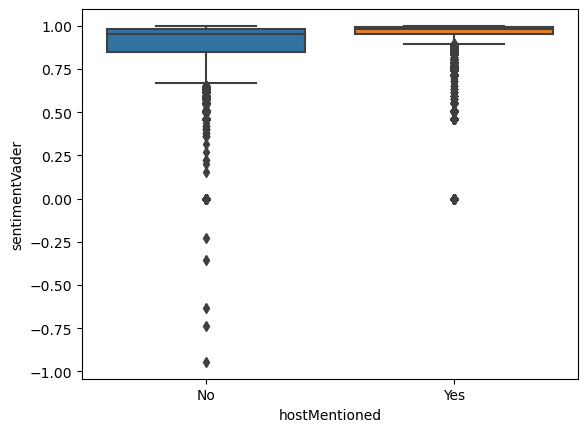

Vader Compound
	Average Sentiment When reviews don't mention the host name: 0.8659604331402927
	Average Sentiment When reviews mention the host name: 0.951038627770823

Roberta positive
	Average Sentiment When reviews don't mention the host name: 0.9519471641387349
	Average Sentiment When reviews mention the host name: 0.9711913287349417

Roberta negative
	Average Sentiment When reviews don't mention the host name: 0.011497567009056001
	Average Sentiment When reviews mention the host name: 0.006560357351570629

Roberta neutral
	Average Sentiment When reviews don't mention the host name: 0.036555269036762476
	Average Sentiment When reviews mention the host name: 0.022248313814719978


In [105]:

#Determine if the hostMentioned feature is significant.
notMentioned=reviews.loc[reviews['hostMentioned']==0,]
mentioned=reviews.loc[reviews['hostMentioned']==1,]
fig,ax=plt.subplots()
sns.boxplot(x='hostMentioned',y='sentimentVader',data=reviews,ax=ax)
ax.xaxis.set_ticklabels(['No','Yes'])

plt.show()

print("Vader Compound")
print('\tAverage Sentiment When reviews don\'t mention the host name:',notMentioned['sentimentVader'].mean())
print('\tAverage Sentiment When reviews mention the host name:',mentioned['sentimentVader'].mean())

print("\nRoberta positive")
print('\tAverage Sentiment When reviews don\'t mention the host name:',notMentioned['posRoberta'].mean())
print('\tAverage Sentiment When reviews mention the host name:',mentioned['posRoberta'].mean())

print("\nRoberta negative")
print('\tAverage Sentiment When reviews don\'t mention the host name:',notMentioned['negRoberta'].mean())
print('\tAverage Sentiment When reviews mention the host name:',mentioned['negRoberta'].mean())

print("\nRoberta neutral")
print('\tAverage Sentiment When reviews don\'t mention the host name:',notMentioned['neutralRoberta'].mean())
print('\tAverage Sentiment When reviews mention the host name:',mentioned['neutralRoberta'].mean())


#  T-test

In [106]:
from scipy.stats import ttest_ind, ttest_ind_from_stats
ttest_ind(notMentioned['sentimentVader'],mentioned['sentimentVader'],equal_var=False)#Two sample t_test


TtestResult(statistic=-170.37547336503644, pvalue=0.0, df=246564.9237175695)

# Lets do word counts for the reviews with the highest and lowest sentiments.

In [107]:

def wordCounts(reviews_df,ignore_words=[],sent_column='sentimentVader',word_type='adjectives'):
    sorted_reviews=reviews_df.sort_values(by=[sent_column],ascending=False)
    negative_reviews=sorted_reviews.tail(3000)
    positive_reviews=sorted_reviews.head(3000)
    neg_adjectives=[]
    pos_adjectives=[]
    
    for i,row in negative_reviews.iterrows():
        neg_adjectives+=negative_reviews.loc[i,word_type]
      
    df=pd.DataFrame({'words':neg_adjectives})
    df=df[~df['words'].isin(ignore_words)]  
    word_count=df['words'].value_counts()
    print(f'Negative Reviews: \n\tColumn Used: {word_type}',word_count.head(10),f'\nSize: {len(negative_reviews)}')
    
    
    for i, row in positive_reviews.iterrows():
        pos_adjectives+=positive_reviews.loc[i,word_type]
    df=pd.DataFrame({'words':pos_adjectives})
    df=df[~df['words'].isin(ignore_words)]  
    word_count=df['words'].value_counts()
    print(f'\nPositive Reviews:\n\tColumn Used: {word_type}',word_count.head(10),f'\nSize: {len(positive_reviews)}')

#wordCounts(reviews, sent_column='posRoberta',word_type='Tokens')
#wordCounts() #word counts for positive and negative reviews based on vader sentiment score.

# Word count using the Tokens column

In [109]:
ignore=["good","bad","house","stay","home","would"]
wordCounts(reviews, sent_column='posRoberta',word_type='Tokens',ignore_words=ignore)

Negative Reviews: 
	Column Used: Tokens words
not      2903
’        1981
place    1150
host      918
night     653
one       624
!         610
u         603
room      582
like      565
Name: count, dtype: int64 
Size: 3000

Positive Reviews:
	Column Used: Tokens words
!              7552
’              1966
place          1807
loved          1083
back           1079
comfortable    1017
Portland        997
location        983
host            961
clean           836
Name: count, dtype: int64 
Size: 3000


# Word count Using the Adjectives column

In [110]:
ignore=["\'","other","bad",'und','great','beautiful','wonderful','good','u','un',"\'","awesome","Great","perfect","nice","Good",'super','amazing']
wordCounts(reviews,ignore_words=ignore,sent_column='posRoberta') 

Negative Reviews: 
	Column Used: adjectives words
’                574
dirty            324
uncomfortable    235
clean            221
old              190
small            183
first            182
next             172
little           158
due              148
Name: count, dtype: int64 
Size: 3000

Positive Reviews:
	Column Used: adjectives words
comfortable    845
clean          705
much           366
best           366
cozy           303
easy           272
little         244
next           236
lovely         217
many           212
Name: count, dtype: int64 
Size: 3000


# Word count using the nouns column 

In [111]:
ignore_words=['Portland',"t",'place','home','house']
wordCounts(reviews, word_type='nouns',sent_column="posRoberta")

Negative Reviews: 
	Column Used: nouns words
place       1107
host         780
house        731
night        565
stay         548
room         510
bathroom     417
door         396
bed          382
unit         371
Name: count, dtype: int64 
Size: 3000

Positive Reviews:
	Column Used: nouns words
place           1650
stay            1215
home            1017
location         974
time             727
space            689
everything       616
house            602
host             516
neighborhood     481
Name: count, dtype: int64 
Size: 3000


# Word counts using adjectives with nouns.

In [112]:
ignore=['great','good','excellent','\'','Bad','und','beautiful','perfect','nice','Portland']
wordCounts(reviews, sent_column='posRoberta',word_type='adjectives_with_nouns',ignore_words=ignore)

Negative Reviews: 
	Column Used: adjectives_with_nouns words
hot water         46
first night       46
next day          44
front door        41
last minute       30
next morning      29
partial refund    28
great location    27
hot tub           25
next door         24
Name: count, dtype: int64 
Size: 3000

Positive Reviews:
	Column Used: adjectives_with_nouns words
great location       133
next time            122
great time           113
great host           109
wonderful stay       103
great stay           100
first time            78
great restaurants     63
perfect location      59
wonderful time        58
Name: count, dtype: int64 
Size: 3000


# The word counts seem to include a lot of words about location.  Lets look at portland and see how sentiment is distributed across it's neighborhoods.

In [113]:
print("Portland Neighborhoods")
print(reviews['neighborhood'].unique())

Portland Neighborhoods
['Concordia' 'Humboldt' 'Overlook' 'King' 'Woodstock' 'Cathedral Park'
 'Mt. Tabor' 'Vernon' 'Buckman' 'Pearl' 'Roseway' 'Reed' 'Goose Hollow'
 'Sellwood-Moreland Improvement League' "Sullivan's Gulch" 'Richmond'
 'Hillsdale' 'Arbor Lodge' 'West Portland Park' 'Eastmoreland' 'Sabin'
 'Irvington' 'Northwest District' 'Forest Park' 'Cully' 'Boise'
 'South Portland' 'Montavilla' 'Sunnyside' 'Southwest Hills' 'Kerns'
 'Rose City Park' 'Marshall Park' 'South Tabor' 'Kenton' 'Woodlawn'
 'Old Town/Chinatown' 'Hayhurst' 'Multnomah' 'Eliot' 'Northwest Heights'
 'North Tabor' 'Portland Downtown' 'Brooklyn Action Corps'
 'Hosford-Abernethy' 'Piedmont' 'Grant Park' 'Laurelhurst'
 'University Park' 'South Burlingame' 'St. Johns' 'Homestead' 'Bridlemile'
 'Creston-Kenilworth' 'Ashcreek' 'Parkrose Heights' 'Foster-Powell'
 'Beaumont-Wilshire' 'Portsmouth' 'Collins View' 'Parkrose' 'Alameda'
 'Arnold Creek' 'Mt. Scott-Arleta' 'Argay' 'Hazelwood'
 'Brentwood-Darlington' 'Madison 

# Get the average sentiment for each neighborhood.

In [114]:


average_sentiment_by_hood=reviews.groupby('neighborhood').agg({'sentimentVader':'mean','posRoberta':'mean'}).reset_index()
average_sentiment_by_hood.head()



,neighborhood,sentimentVader,posRoberta
0,Alameda,0.886195,0.961375
1,Arbor Lodge,0.883811,0.958085
2,Ardenwald-Johnson Creek,0.845829,0.942201
3,Argay,0.878094,0.950311
4,Arlington Heights,0.892941,0.967173


In [115]:
import geopandas as gpd
geo=gpd.read_file('neighbourhoods.geojson')
merged_geo=pd.merge(geo,average_sentiment_by_hood,left_on='neighbourhood', right_on='neighborhood', how='inner')
merged_geo.head()

,neighbourhood,neighbourhood_group,geometry,neighborhood,sentimentVader,posRoberta
0,Sullivan's Gulch,None,"MULTIPOLYGON Z (((-122.65049 45.53504 0.00000,...",Sullivan's Gulch,0.873986,0.945926
1,Hollywood,None,"MULTIPOLYGON Z (((-122.62501 45.53778 0.00000,...",Hollywood,0.879657,0.948917
2,Hillside,None,"MULTIPOLYGON Z (((-122.72434 45.52605 0.00000,...",Hillside,0.889193,0.958094
3,Sylvan-Highlands,None,"MULTIPOLYGON Z (((-122.72242 45.51470 0.00000,...",Sylvan-Highlands,0.867469,0.948093
4,Arbor Lodge,None,"MULTIPOLYGON Z (((-122.67859 45.57721 0.00000,...",Arbor Lodge,0.883811,0.958085


In [116]:
def plotGeo(sent_column):
    fig, ax =plt.subplots(figsize=(24,21))
    merged_geo.plot(column=sent_column,
                   cmap='YlGnBu_r',
                   linewidth=1,
                   legend=True,
                   ax=ax,
                   legend_kwds={'label':'Review sentiment'})
    merged_geo.apply(lambda x: ax.annotate(text=x['neighbourhood'], xy=x.geometry.centroid.coords[0], ha='center', size=17),
                     axis=1)
    plt.suptitle('Roberta Positive Sentiment  By Neighborhood',fontsize=20,fontweight='bold')
    cb_ax = fig.axes[1] 
    #cbar = fig.colorbar(cb_ax)
    
    #cb_ax = fig.axes[1] 
    cb_ax.tick_params(labelsize=18)
    #cbar.ax.tick_params(labelsize=18)
    ax.axis('off')
    plt.tight_layout()
    #plt.savefig('cloroplethPorland.png')
    plt.show()

# Geographic plot using Vader compound as the sentiment column.

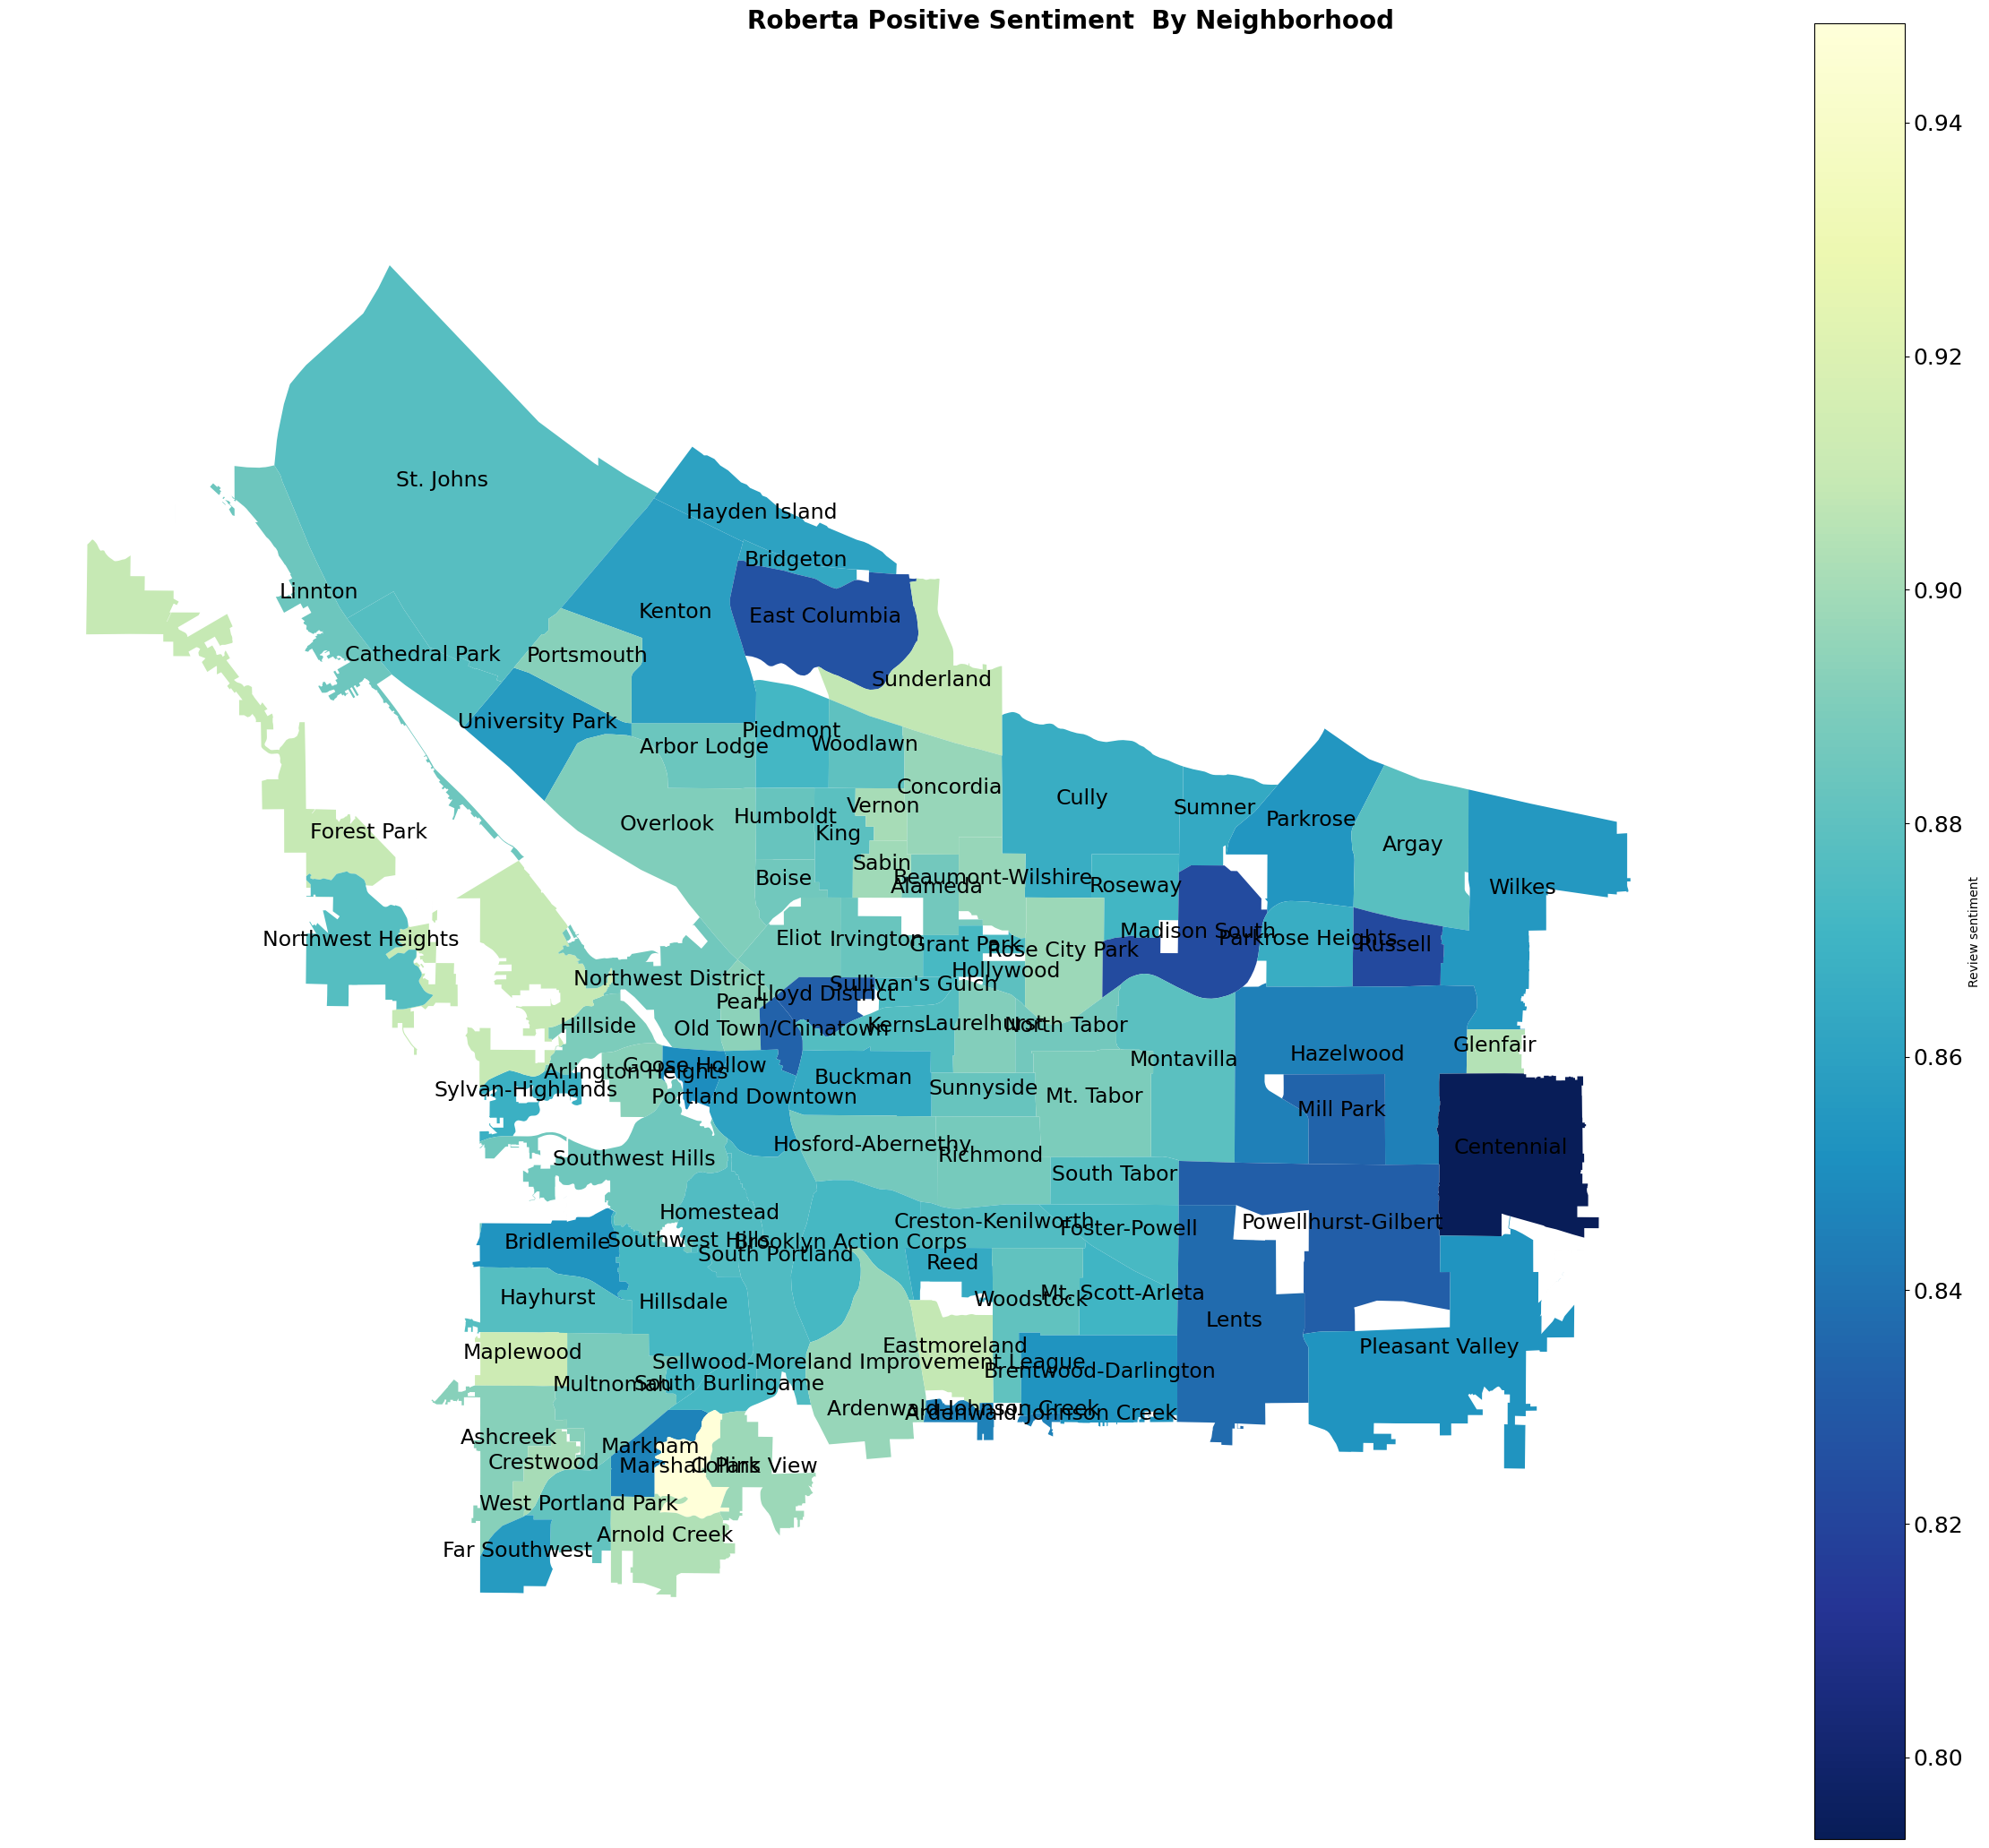

In [117]:
plotGeo('sentimentVader')

# Plot using roberta positive score as the sentiment column.

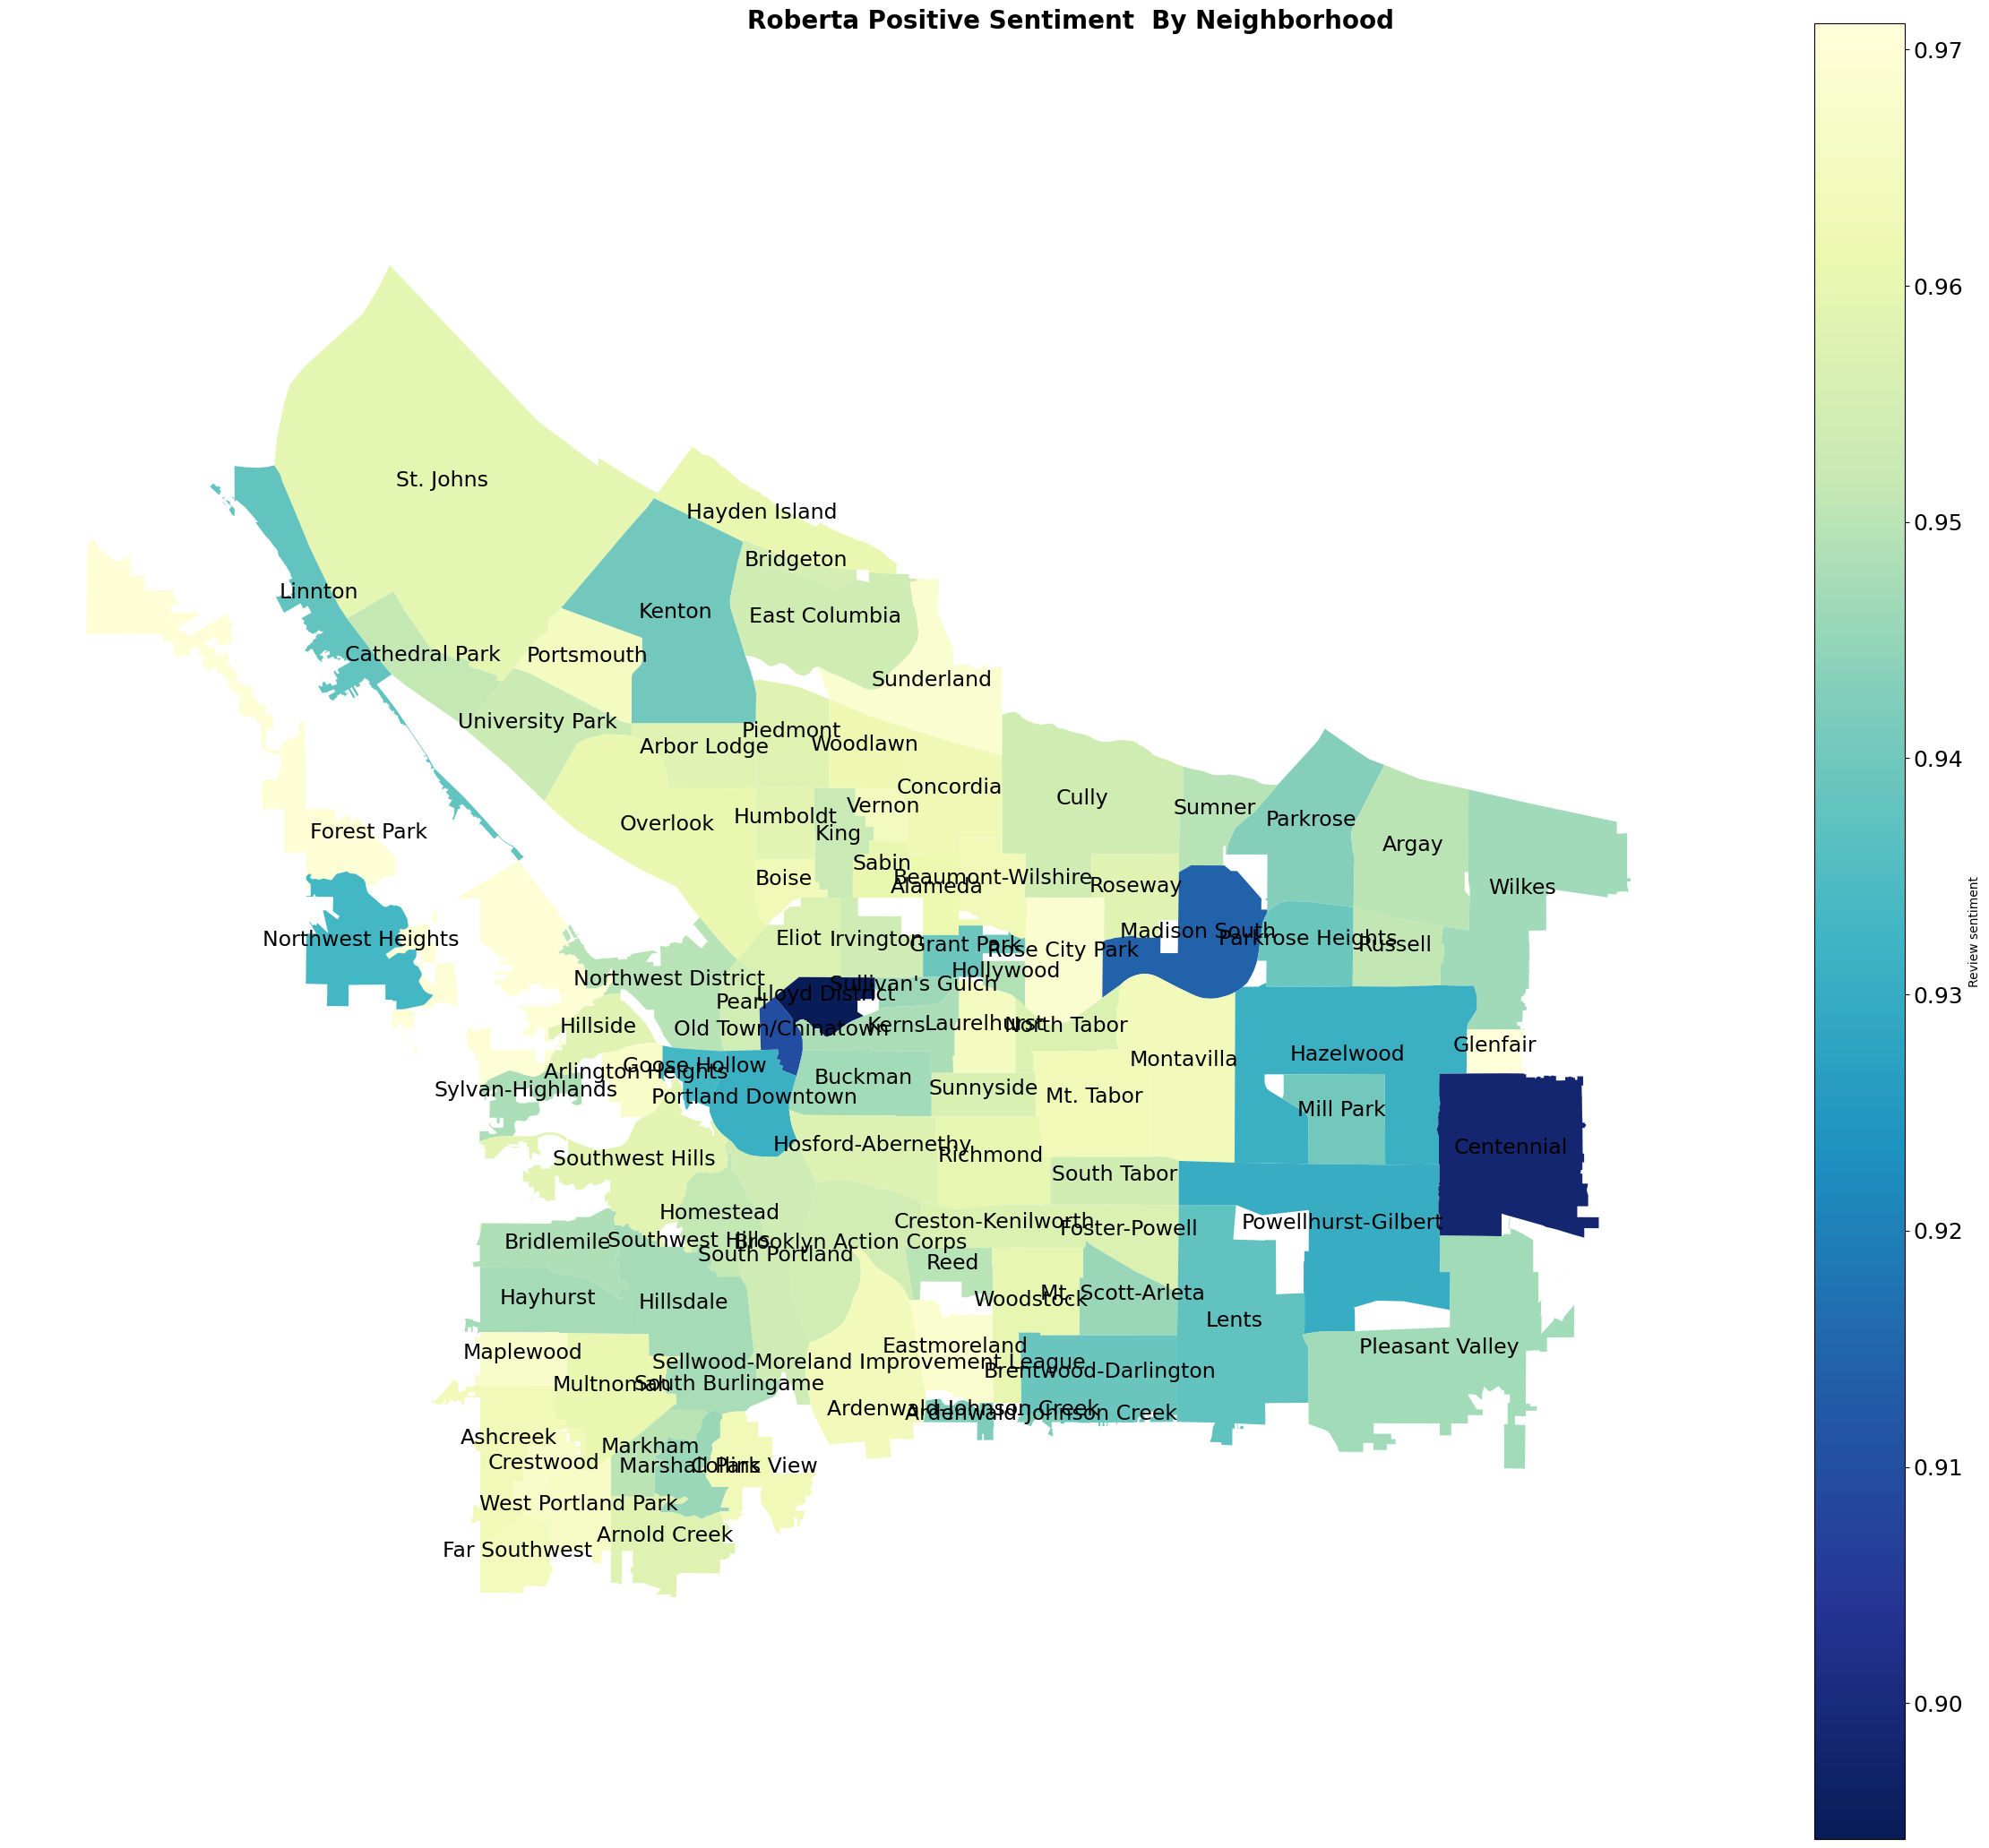

In [118]:
plotGeo('posRoberta')


## The choropleth suggests that positive sentiment is less prevalent in certain geographical areas.  In particular the graph shows that the southeast side of Portland is less associated with positive reviews.  After seeing this we decided to further investigate geographic location as a factor by breaking the city in sextants (6 geographic regions),